# Inferencia causal en modelos bayesianos: Exploración y aplicación del deconfounder en análisis de datos observacionales

Leila Sofía Asplanato - ICIFI, ICAS, ECyT, UNSAM (Bs. As.)

--------------------------------------------------
--------------------------------------------------

# Deconfounder tutorial

Vamos a aplicar el modelo de factores y de resultados, posterior a realizar el chequeo predictivo, al dataset abierto de cáncer de mamas de Scikit-Learn.

Base de datos de pacientes diagnosticados en base a estudios de cáncer de mama en Wisconsin, del año 1995 [1].
La misma cuenta con mediciones de atributos relevantes para la clasificación de tumores a partir del análisis de propiedades de núcleos celulares en las muestras histológicas de aspirado en punción de tejidos mamarios, y está disponible de manera libre en Scikit-Learn.
Dicha base de datos cuenta con 569 muestras reales con 32 atributos sin valores faltantes.
Del total de los atributos computados, los relevantes en nuestro análisis son las 10 variables de valores promedio (números reales) de cada núcleo. Como target, se tiene el diagnóstico del tumor, maligno o benigno codificado con 1 o 0 respectivamente, los cuales se distribuyen en 212 unidades malignas y 357 benignas. Las variables descartadas del análisis son los errores estándar de cada categorı́a, y los llamados ‘peores valores’ que serı́an los máximos encontrados, o el promedio de los tres mayores, en toda la muestra histológica.


[1] *Dheeru Dua and Casey Graff. UCI machine learning repository, 2017. University of California, Irvine, School of Information and Computer Sciences http://archive.ics.uci.edu/ml*

In [ ]:
# Importamos librerías de interés y seteamos semilla para reproducibilidad
import numpy as np
import numpy.random as npr
import pandas as pd

from sklearn.datasets import load_breast_cancer
from scipy import sparse, stats

import matplotlib
matplotlib.rcParams.update({'font.sans-serif' : 'Helvetica',
                            'axes.labelsize': 10,
                            'xtick.labelsize' : 6,
                            'ytick.labelsize' : 6,
                            'axes.titlesize' : 10})
import matplotlib.pyplot as plt

import seaborn as sns
color_names = ["windows blue",
               "amber",
               "crimson",
               "faded green",
               "dusty purple",
               "greyish"]
colors = sns.xkcd_palette(color_names)
sns.set(style="white", palette=sns.xkcd_palette(color_names), color_codes = False)

%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import gc

import random
randseed = 123
print("random seed: ", randseed)
random.seed(randseed)
rng = np.random.RandomState(randseed)

random seed:  123


## Importamos los datos

(569, 10)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


((569,),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0]))

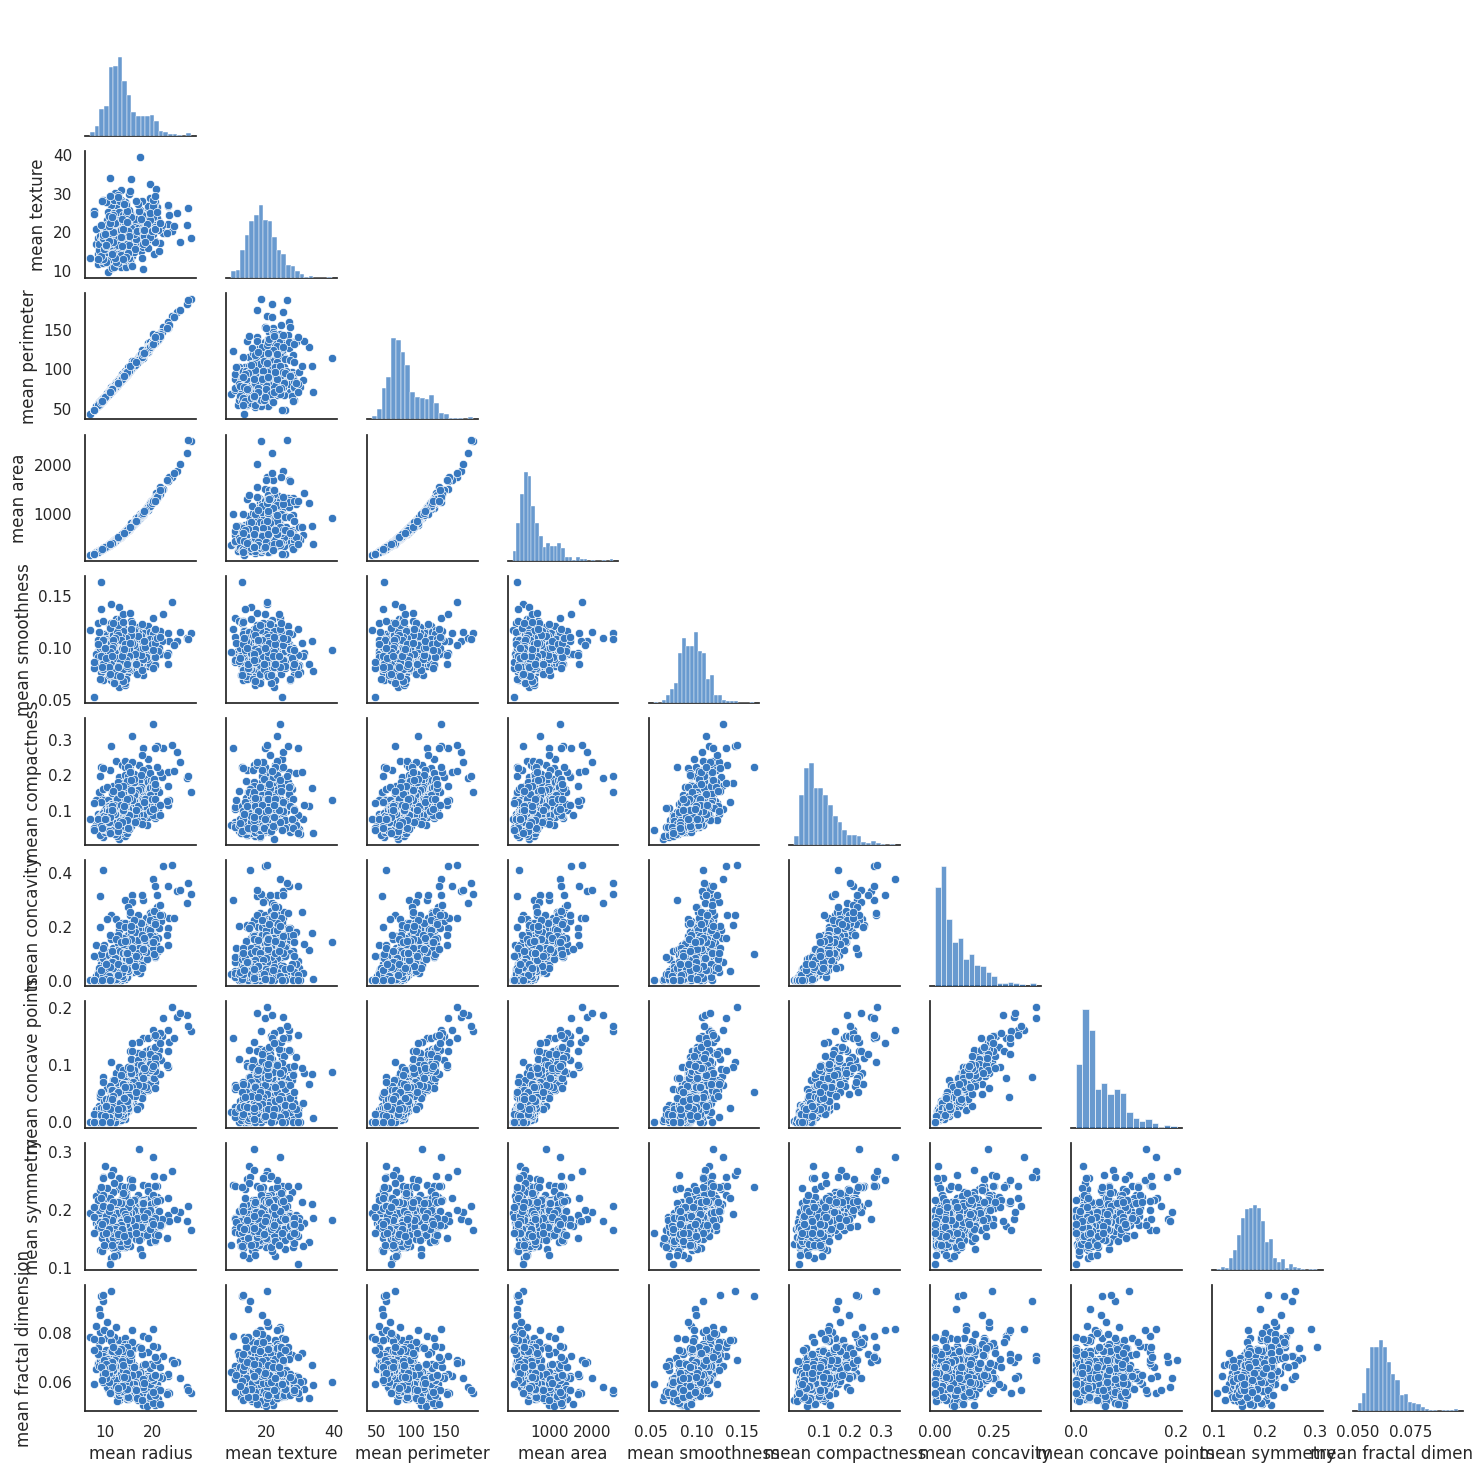

In [ ]:
data = load_breast_cancer()
# print(data['DESCR'])
# data
# type(data)
num_features = 10
df = pd.DataFrame(data["data"][:,:num_features], columns=data["feature_names"][:num_features])

df.shape
df.head()

#define binary outcomes
dfy = data["target"]
dfy.shape, dfy[:100] # binary outcomes

_ = sns.pairplot(df, height=1.5, corner = True)

Para el deconfounder, tenemos que eliminar las variables de intervención altamente correlacionadas entre sí.
En esos casos, la confundidora sustituta sería una función deterministica de una de las variables, que viola la hipótesis de *overlap*.

In [ ]:
# El perímetro y el área están altamente correlacionadas con el radio, los sacamos de nuestras variables de estudio causal
fea_cols = df.columns[[(not df.columns[i].endswith("perimeter")) \
                     and (not df.columns[i].endswith("area")) \
                     for i in range(df.shape[1])]]

dfX = pd.DataFrame(df[fea_cols])

print(dfX.shape, dfy.shape)

# Estandarización de las variables
X = np.array((dfX - dfX.mean())/dfX.std())

(569, 8) (569,)


## Chequeo predictivo
### Enmascaramiento de datos

Vamos a ocultar, al azar, valores de la matriz de variables/intervenciones. Para eso tomamos su tamaño para generan los índices a ocultar, según la fracción deseda.

In [ ]:
num_datapoints, data_dim = X.shape

holdout_portion = 0.2 #20% aproximado de datos ocultos
n_holdout = int(holdout_portion * num_datapoints * data_dim)
print('n_holdout', n_holdout)

# Genero los vectores de coordenadas al samplear "n_holdout" de cada uno
holdout_row = np.random.randint(num_datapoints, size=n_holdout)
holdout_col = np.random.randint(data_dim, size=n_holdout)


holdout_mask = (sparse.coo_matrix((np.ones(n_holdout),(holdout_row, holdout_col)),
                                  shape = X.shape)).toarray()

holdout_mask = np.minimum(1, holdout_mask) #los repetidos se suman

holdout_subjects = np.unique(holdout_row) #tomo las observaciones que tienen datos ocultos

print('holdout_mask shape', holdout_mask.shape)
print('holdout_mask =')
print(holdout_mask[:3,:])

n_holdout 910
holdout_mask shape (569, 8)
holdout_mask =
[[0. 0. 1. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 0.]]


Oculto los datos de la matriz multiplicándola por 1-H (vemos los que NO retuvimos).

In [ ]:
x_train = np.multiply(1-holdout_mask, X)
x_vad = np.multiply(holdout_mask, X)

## Modelado

In [ ]:
import pymc as pm
import pymc.sampling_jax
import arviz as az

In [ ]:
pip install numpyro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.1/348.1 kB 9.5 MB/s eta 0:00:00


Definición de los modelos de factores para el chequeo predictivo y los argumentos de muestreo para la inferencia.

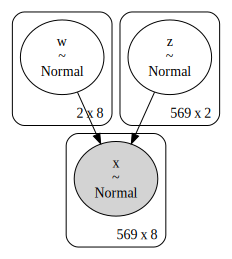

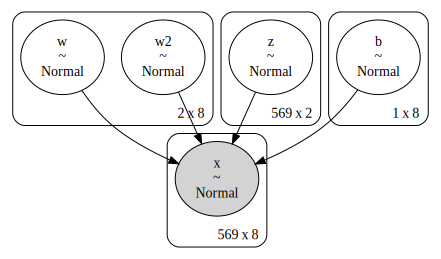

In [ ]:
# Damos la opción de modelado lineal y cuadrático
# Lineal: x_n con media z_n * W
# Cuadrático: x_n con media b + z_n * W + (z_n**2) * W_2

def factor_model_mask(data, data_dim, latent_dim, num_datapoints, stddv_datapoints, mask,
                    sigma_prior = 1, form = 'linear', mu_w = 0):
    with pm.Model() as model:
        w = pm.Normal('w', mu = mu_w,
                      sigma = sigma_prior,
                      shape = (latent_dim, data_dim))

        z = pm.Normal('z', mu = 0,
                      sigma = sigma_prior,
                      shape = (num_datapoints, latent_dim))

        if form == 'linear':
            x = pm.Normal('x', mu = (pm.math.dot(z,w))*mask,
                         sigma = stddv_datapoints,
                         #shape = (num_datapoints, data_dim),
                         observed = data)


        elif form == 'quadratic':
            b = pm.Normal('b', mu = 0,
                         sigma = 1,
                         shape = (1, data_dim))
            w2 = pm.Normal('w2', mu = mu_w,
                          sigma = 1,
                          shape = (latent_dim, data_dim))
            x = pm.Normal('x', mu = (b + pm.math.dot(z,w) + pm.math.dot(np.square(z),w2))*mask,
                         sigma = stddv_datapoints,
                         shape = (num_datapoints, data_dim),
                         observed = data)
        return model

latent_dim = 2
stddv_datapoints = 0.1

#Recordatorio: x_train = np.multiply(1-holdout_mask, X)

model = factor_model_mask(data = x_train,
                        data_dim=data_dim,
                        latent_dim=latent_dim,
                        num_datapoints=num_datapoints,
                        stddv_datapoints=stddv_datapoints,
                        mask=1-holdout_mask)

model_quad = factor_model_mask(data = x_train,
                        data_dim=data_dim,
                        latent_dim=latent_dim,
                        num_datapoints=num_datapoints,
                        stddv_datapoints=stddv_datapoints,
                        mask=1-holdout_mask,
                        form = 'quadratic')
pm.model_to_graphviz(model)
pm.model_to_graphviz(model_quad)

# Sección de argumentos y funciones para muestreo
draws = 8000
tune = 4000
chains = 5
kwargs = {'log_likelihood': False}
target = 0.9
def run_model(pymc_model,target, draws = 3000, tune = 3000, chains = 8):
    with pymc_model:
        idata = pm.sampling_jax.sample_numpyro_nuts(draws = draws, tune = tune, chains = chains, target_accept=target)
    return idata

# Por una cuestión computacional, vamos a eliminar el paso de cálculo de log_likelihood de las muestras (tiempo y memoria)
def run_model_no_log(model, draws = draws, tune = tune, chains = chains,
                     kwargs = {'log_likelihood': False}, target = target):
    with model:
        idata = pm.sampling_jax.sample_numpyro_nuts(draws = draws, tune = tune,
                                                    chains = chains, idata_kwargs=kwargs,
                                                    target_accept = target)
        gc.collect()
    return idata


In [ ]:
%%time
idata = run_model_no_log(model, target = target, draws = draws, tune = tune, chains = chains)

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

CPU times: user 11min 14s, sys: 6.18 s, total: 11min 20s
Wall time: 8min 30s


0

In [ ]:
%%time
idata_quad = run_model_no_log(model_quad, target = target, draws = draws, tune = tune, chains = chains)

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

CPU times: user 23min 20s, sys: 6.46 s, total: 23min 27s
Wall time: 16min 3s


0

In [ ]:
# idata.to_netcdf("/home/investigacion_ecyt/Downloads/temp/bayesplurinacional/idata", compress = False)
# idata_quad.to_netcdf("/home/investigacion_ecyt/Downloads/temp/bayesplurinacional/idata_quad", compress = False)
# lin_index = np.argmax(idata.sample_stats.lp.values.mean(axis = 1).round(2))
# quad_index = np.argmax(idata_quad.sample_stats.lp.values.mean(axis = 1).round(2))
# idata_1 = idata.sel(chain = [lin_index])
# idata_quad_1 = idata_quad.sel(chain = [quad_index])

## Chequeo predictivo

holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True


holdout_gen same for linear and quadratic: True
mean values [0.06026786 0.11419643]
std values [0.00780931 0.01244695]


<timed exec>:90: UserWarning: FixedFormatter should only be used together with FixedLocator


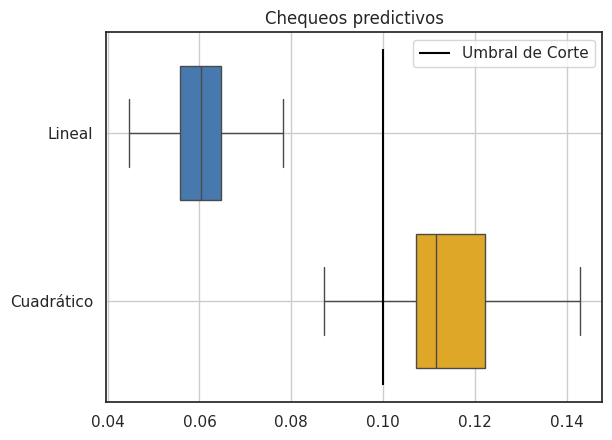

CPU times: user 3min 34s, sys: 16.6 s, total: 3min 51s
Wall time: 4min 4s


In [ ]:
%%time
def posterior_sampling_thinned(pymc_model, data, thinned_by, return_data = False, variables = ["x"]):
    with pymc_model:
        posterior = pm.sample_posterior_predictive(data.sel(draw=slice(None, None, thinned_by)), return_inferencedata = return_data, var_names = variables)
    return posterior

holdout_subjects = np.unique(holdout_row)
p = 50
full_p_values = np.zeros((p,2))

for p in range(p):
    thinned_by = 10
    idata_posterior = posterior_sampling_thinned(model, idata, thinned_by, return_data = True, variables = ["x", "w", "z"])
    idata_posterior_quad = posterior_sampling_thinned(model_quad, idata_quad, thinned_by, return_data = True, variables = ["x", "w", "z", "w2"])
    idata_posterior = idata_posterior.stack(sample=["chain", "draw"])
    idata_posterior_quad = idata_posterior_quad.stack(sample=["chain", "draw"])
    rng = np.random.RandomState(123)
    lista = list(range(0,250))
    rng.shuffle(lista)
    n_rep, n_eval = 100,100
    x_generated = idata_posterior.posterior_predictive['x'].values[:,:,lista[:n_rep]]
    x_generated_quad = idata_posterior_quad.posterior_predictive['x'].values[:,:,lista[:n_rep]]

    w_sample = idata_posterior.posterior_predictive["w"].values[:,:,lista[:n_rep]]
    z_sample = idata_posterior.posterior_predictive["z"].values[:,:,lista[:n_rep]]

    ##### QUAD MODEL VARIABLES  #####
    w_sample_quad = idata_posterior_quad.posterior_predictive['w'].values[:,:,lista[:n_rep]]
    z_sample_quad = idata_posterior_quad.posterior_predictive['z'].values[:,:,lista[:n_rep]]
    w2_sample_quad = idata_posterior_quad.posterior_predictive['w2'].values[:,:,lista[:n_rep]]

    holdout_gen = np.zeros_like(x_generated) #(n_rep,*(x_train.shape)) where n_rep =12000
    holdout_gen_quad = np.zeros_like(x_generated_quad)

    for i in range(n_rep):
        holdout_gen[:,:,i] = np.multiply(x_generated[:,:,i],holdout_mask)
        holdout_gen_quad[:,:,i] = np.multiply(x_generated_quad[:,:,i],holdout_mask)

    ##### TEST STATISTIC OF EXPECTED LOG LIKELIHOOD  #####
    obs_ll = []
    rep_ll = []
    for j in range(n_eval): #corre n_evañ = 100 veces
            holdoutmean_sample = np.multiply(z_sample[:,:,j].dot(w_sample[:,:,j]), holdout_mask)
            obs_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(x_vad), axis=1))

            rep_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(holdout_gen[:,:,j]),axis=1))

    obs_ll_per_zi, rep_ll_per_zi = np.mean(np.array(obs_ll), axis=0), np.mean(np.array(rep_ll), axis=0)


    ##### TEST STATISTIC OF EXPECTED LOG LIKELIHOOD  #####
    obs_ll_quad = []
    rep_ll_quad = []
    for j in range(n_eval):
            holdoutmean_sample = np.multiply(np.dot(z_sample_quad[:,:,j],w_sample_quad[:,:,j]) + np.dot(np.square(z_sample_quad[:,:,j]),w_sample_quad[:,:,j]), holdout_mask)
            obs_ll_quad.append(np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(x_vad), axis=1))

            rep_ll_quad.append(np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(holdout_gen[:,:,j]),axis=1))

    obs_ll_per_zi_quad, rep_ll_per_zi_quad = np.mean(np.array(obs_ll_quad), axis=0), np.mean(np.array(rep_ll_quad), axis=0)

## P-valores chequeo predictivo
    pvals = np.array([np.mean(rep_ll_per_zi[i] < obs_ll_per_zi[i]) for i in range(num_datapoints)])
    holdout_subjects = np.unique(holdout_row)
    overall_pval = np.mean(pvals[holdout_subjects])

    pvals_quad = np.array([np.mean(rep_ll_per_zi_quad[i] < obs_ll_per_zi_quad[i]) for i in range(num_datapoints)])
    holdout_subjects = np.unique(holdout_row)
    overall_pval_quad = np.mean(pvals_quad[holdout_subjects])

    full_p_values[p,0] = np.mean(pvals[holdout_subjects])
    full_p_values[p,1] = np.mean(pvals_quad[holdout_subjects])

    gc.collect()

# Visualización de resultados
print('mean values', np.mean(full_p_values, axis = 0))
print('std values', np.std(full_p_values, axis = 0))

ax = sns.boxplot(full_p_values, orient = "h")
_ = ax.set_title("Chequeos predictivos")
_ = ax.get_ylim()
_ = ax.vlines(0.1, ymin=-0.5, ymax=1.5, label= "Umbral de Corte", colors = "k")

_ = ax.legend()
_ = ax.grid(True)
_ = ax.set_yticklabels(["Lineal", "Cuadrático"])
plt.show()

## Modelo de Factores completo
Una vez resuelto qué modelo supera el chequeo predictivo, se aplica el modelo de factores para conseguir las variables confundidoras sustitutas.
En este caso usamos el modelo cuadrático, ya que p > 0.1.

Modelo de factores sin enmascarar


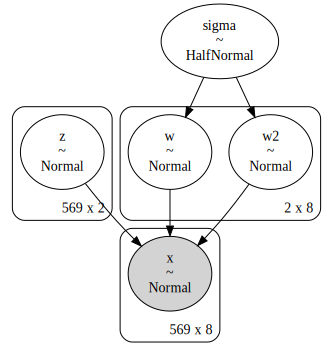

In [ ]:
def factor_model(data, data_dim, latent_dim, num_datapoints, stddv_datapoints,
                    sigma_prior = 1, form = 'linear', mu_w = 0):
    with pm.Model() as model:

        z = pm.Normal('z', mu = 0,
                      sigma = sigma_prior,
                      shape = (num_datapoints, latent_dim))

        sigma_w = pm.HalfNormal("sigma", sigma=1)
        #sw = pm.Normal('sw', mu = sigma_w, sigma = sigma_w_sd)

        w = pm.Normal('w', mu = mu_w,
                      sigma = sigma_w,
                      shape = (latent_dim, data_dim))

        if form == 'linear':
            mu_likelihood = pm.math.dot(z,w)


        elif form == 'quadratic':
            w2 = pm.Normal('w2', mu = mu_w,
                          sigma = sigma_w,
                          shape = (latent_dim, data_dim))

            mu_likelihood = pm.math.dot(z,w) + pm.math.dot(np.square(z),w2)

        x = pm.Normal('x', mu = mu_likelihood,
                         sigma = stddv_datapoints,
                         shape = (num_datapoints, data_dim),
                         observed = data)
        return model


full_model_quad = factor_model(data = X,
                             data_dim = data_dim,
                             latent_dim = latent_dim,
                             num_datapoints=num_datapoints,
                             stddv_datapoints=stddv_datapoints,
                             form = 'quadratic')
print("Modelo de factores sin enmascarar")
pm.model_to_graphviz(full_model_quad)

In [ ]:
%%time
full_idata_quad = run_model_no_log(full_model_quad)

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

In [ ]:
# # full_idata_quad.to_netcdf("/home/investigacion_ecyt/Downloads/temp/bayesplurinacional/full_idata_quad", compress = False)
# full_idata_quad.sample_stats.lp.values.mean(axis = 1).round(2)
# full_quad_index = np.argmax(full_idata_quad.sample_stats.lp.values.mean(axis = 1).round(2))
# full_quad_index
# full_idata_quad = full_idata_quad.sel(chain = [full_quad_index])

array([45803.25, 44544.05, 42413.76, 48423.47, 45345.67])

3

### Utilizamos valores de inferencia para reemplazar las variables confundidoras en el modelo de resultados

In [ ]:
# Definición de funciones de resumen
def median_sd(x):
    median = np.percentile(x, 50)
    sd = np.sqrt(np.mean((x-median)**2))
    return sd

def mode(x):
    binned = int(np.sqrt(len(x))/2)
    counts,bins = np.histogram(x, bins = binned)
    peak = np.argmax(counts)
    mode = np.mean((bins[peak], bins[peak+1]))
    return mode

func_dict = {
    'mean': np.mean,
    "std": np.std,
    'mode':mode,
    "5%": lambda x: np.percentile(x, 5),
    "median": lambda x: np.percentile(x, 50),
    "95%": lambda x: np.percentile(x, 95),
    "median_std": median_sd
}

def get_summary(data, var_name, dictionary = func_dict):
    summary = az.summary(data, stat_funcs = dictionary, extend = False, var_names = var_name)
    print(summary)
    return summary

In [ ]:
full_summary_z = az.summary(full_idata_quad.posterior, stat_funcs = func_dict, extend = False, var_names = ['z'])
full_summary_w = az.summary(full_idata_quad.posterior, stat_funcs = func_dict, extend = False, var_names = ['w'])
full_summary_w2 = az.summary(full_idata_quad.posterior, stat_funcs = func_dict, extend = False, var_names = ['w2'])


z_mean_vals = full_summary_z['mean'].values.reshape((-1,latent_dim))
z_sd_vals = full_summary_z['std'].values.reshape((-1,latent_dim))
z_mean_vals.mean(axis = 0)
z_sd_vals.mean(axis = 0)
np.shape(z_mean_vals)

# w_mean_vals = full_summary_w['mean'].values.reshape((latent_dim, data_dim))
# w_sd_vals = full_summary_w['std'].values.reshape((latent_dim, data_dim))
# print('w')
# w_mean_vals
# w_sd_vals
# np.shape(w_mean_vals)

# w2_mean_vals = full_summary_w2['mean'].values.reshape((latent_dim, data_dim))
# w2_sd_vals = full_summary_w2['std'].values.reshape((latent_dim, data_dim))
# print('w2')
# w2_mean_vals
# w2_sd_vals
# np.shape(w2_mean_vals)

# f_ = plt.figure()
# t_ = plt.title("W", fontsize = 14)
# ax = sns.heatmap(np.abs(w_mean_vals)/w_sd_vals, cmap='coolwarm',linecolor='white', lw = 1)
# for (i, j), z in np.ndenumerate(w_mean_vals):
#     t_ = ax.text(j+1/2, i+1/2, '{:0.2f}'.format(z), ha='center', va='center', size = 'medium')
# plt.show()

# f_ = plt.figure()
# t_ = plt.title("W2", fontsize = 14)
# ax = sns.heatmap(np.abs(w2_mean_vals)/w2_sd_vals, cmap='coolwarm',linecolor='white', lw = 1)
# for (i, j), z in np.ndenumerate(w2_mean_vals):
#     t_ = ax.text(j+1/2, i+1/2, '{:0.2f}'.format(z), ha='center', va='center', size = 'medium')
# plt.show()


## Modelo de resultados (Outcome model)

In [ ]:
def outcome(z_observed, dfy = dfy, X = X):
    target_dim = 1 #(y es 0,1 dejó o no)
    mu_prior = 0
    sigma_prior = 1

    with pm.Model() as outcome_model:

        beta = pm.Normal('beta', mu =  mu_prior,
                      sigma = sigma_prior,
                      shape = data_dim)

        gamma = pm.Normal('gamma', mu =  mu_prior,
                      sigma = sigma_prior,
                      shape = latent_dim)
        score = pm.Deterministic('score', pm.math.dot(X,beta) + pm.math.dot(z_observed,gamma))

        likelihood = pm.Deterministic('like', pm.invlogit(score)) #+b

        y = pm.Bernoulli('logit_y', p = likelihood, observed = dfy)
    return outcome_model

outcome_model = outcome(z_mean_vals, dfy = dfy, X=X)
pm.model_to_graphviz(outcome_model)

In [ ]:
%%time
outcome_data = run_model_no_log(outcome_model)
# outcome_data.to_netcdf("/home/investigacion_ecyt/Downloads/temp/bayesplurinacional/outcome_data", compress = False)

In [ ]:
outcome_summary = get_summary(outcome_data, var_name = ["beta", "gamma"])

my_causes_mean = outcome_summary["mean"].values
my_causes_sd = outcome_summary["std"].values

# Tomamos los valores y desviaciones reportadas por los autores del paper de presentación del deconfounder
blei_causes_mean = np.array((2.97783,-1.44867, -1.46326,0.368069,-1.13524, -1.65108, -0.536826,0.416358, 0.3544, -1.0729)).round(2)
blei_causes_std = np.array((0.964373,0.380799, 0.743651, 0.87232, 0.90044, 1.23964, 0.506479, 0.765082, 1.734, 1.360)).round(3)
blei_causes_min = (blei_causes_mean-blei_causes_std).round(2)
blei_causes_max = (blei_causes_mean+blei_causes_std).round(2)
nombres = ["Radio medio(*)", "Textura media", "Suavidad media", "Compacticidad media", "Concavidad media", "Puntos concavos medios", "Simetría Media", "Dimensión fractal media", "Confundidora 1", "Confundidora 2"]
axs = az.plot_posterior(outcome_data, var_names = ["beta", "gamma"], ref_val = list(blei_causes_mean), grid = (4,3))
index = 0

for i in range(4):
    for j in range(3):
        if index < len(nombres):
            _ = axs[i, j].set_title(nombres[index], size=16)
            _ = axs[i, j].axvspan(xmin=blei_causes_min[index], xmax=blei_causes_max[index], facecolor="#B0C4DE", alpha=0.2)
        index += 1  # Increment the index after each subplot
plt.show()

Compiling...
Compilation time =  0:00:00.668296
Sampling...


  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

Sampling time =  0:00:06.277496
Transforming variables...
Transformation time =  0:00:00.309955


'/home/investigacion_ecyt/Downloads/temp/bayesplurinacional/outcome_data_all_chains'

           mean    std   mode     5%  median    95%  median_std
beta[0]  -2.550  0.533 -2.560 -3.442  -2.542 -1.690       0.533
beta[1]  -1.010  0.247 -1.005 -1.422  -1.006 -0.609       0.247
beta[2]  -0.784  0.332 -0.791 -1.334  -0.781 -0.246       0.332
beta[3]   0.508  0.503  0.478 -0.320   0.511  1.332       0.503
beta[4]  -1.358  0.470 -1.354 -2.131  -1.357 -0.584       0.470
beta[5]  -2.060  0.651 -1.955 -3.146  -2.050 -0.994       0.651
beta[6]  -0.335  0.264 -0.303 -0.766  -0.335  0.098       0.264
beta[7]   0.363  0.418  0.448 -0.321   0.359  1.059       0.418
gamma[0]  0.668  0.567  0.701 -0.266   0.668  1.606       0.567
gamma[1] -1.566  0.538 -1.453 -2.454  -1.565 -0.686       0.538


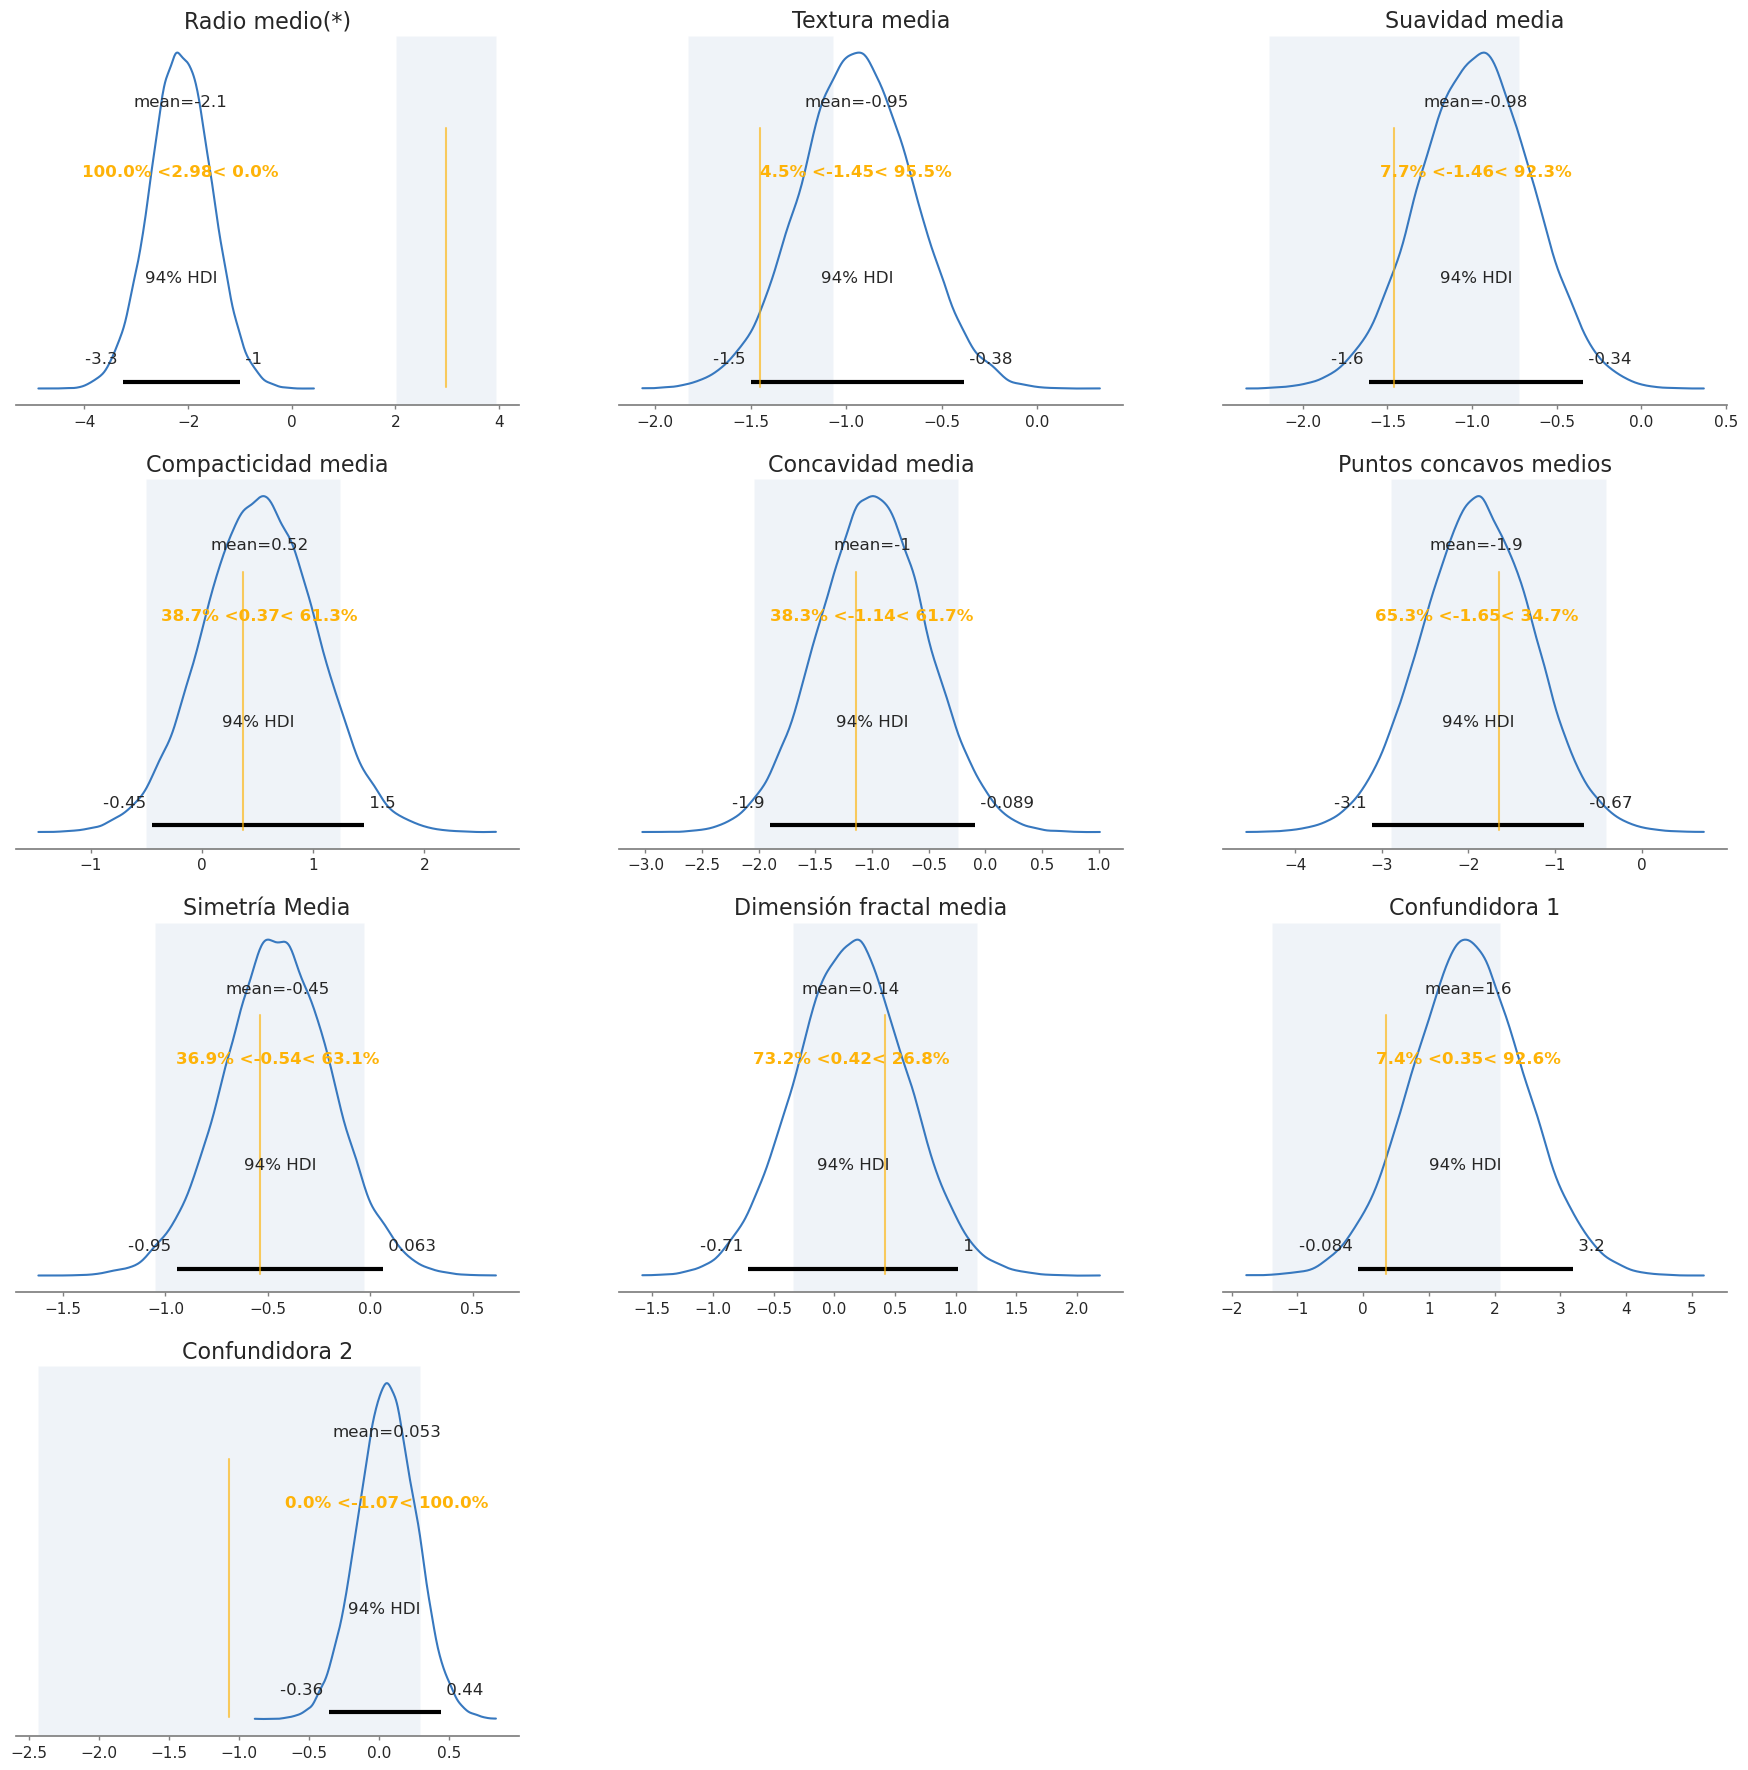

In [ ]:
outcome_model = outcome(z_mean_vals, dfy = dfy, X=X)
outcome_data_all_chains = run_model_no_log(outcome_model)
outcome_data_all_chains.to_netcdf("/home/investigacion_ecyt/Downloads/temp/bayesplurinacional/outcome_data_all_chains", compress = False)
outcome_summary = get_summary(outcome_data_all_chains, var_name = ["beta", "gamma"])

my_causes_mean = outcome_summary["mean"].values
my_causes_sd = outcome_summary["std"].values

# Tomamos los valores y desviaciones reportadas por los autores del paper de presentación del deconfounder
blei_causes_mean = np.array((2.97783,-1.44867, -1.46326,0.368069,-1.13524, -1.65108, -0.536826,0.416358, 0.3544, -1.0729)).round(2)
blei_causes_std = np.array((0.964373,0.380799, 0.743651, 0.87232, 0.90044, 1.23964, 0.506479, 0.765082, 1.734, 1.360)).round(3)
blei_causes_min = (blei_causes_mean-blei_causes_std).round(2)
blei_causes_max = (blei_causes_mean+blei_causes_std).round(2)
nombres = ["Radio medio(*)", "Textura media", "Suavidad media", "Compacticidad media", "Concavidad media", "Puntos concavos medios", "Simetría Media", "Dimensión fractal media", "Confundidora 1", "Confundidora 2"]
axs = az.plot_posterior(outcome_data, var_names = ["beta", "gamma"], ref_val = list(blei_causes_mean), grid = (4,3))
index = 0

for i in range(4):
    for j in range(3):
        if index < len(nombres):
            _ = axs[i, j].set_title(nombres[index], size=16)
            _ = axs[i, j].axvspan(xmin=blei_causes_min[index], xmax=blei_causes_max[index], facecolor="#B0C4DE", alpha=0.2)
        index += 1  # Increment the index after each subplot
plt.show()

# Otros materiales/bibliografía de interés

* [Repositorio de algoritmos causales](https://github.com/rguo12/awesome-causality-algorithms)
* [Naive regression requires weaker assumptions than factor
models to adjust for multiple cause confounding - 2023](https://dcknox.github.io/files/GrimmerKnoxStewart_NaiveRegressionDeconfounder.pdf)